In [3]:
import duckdb
import os

con = duckdb.connect()
    
#read in the following file to duckdb
con.execute("INSTALL parquet; LOAD parquet;")
con.execute("CREATE OR REPLACE VIEW traffic_stops AS SELECT * FROM read_parquet('preprocessed-data/tx_austin_2020_04_01_preprocessed.parquet')")
    
# tx_austin_2020_04_01_preprocessed.parquet 

#print out the min and max dates from the date column
result = con.execute("SELECT MIN(date), MAX(date) FROM traffic_stops").fetchone()
print(f"Min date: {result[0]}, Max date: {result[1]}")

Min date: 2006-01-01, Max date: 2016-06-30


In [1]:
# go through all the files in preprocessed-date and print out the min and max dates from the date column. list those that contain the ENTIRE year of 2017
import glob
import os
import duckdb

con = duckdb.connect()
con.execute("INSTALL parquet; LOAD parquet;")

files_with_2017 = []

for file in glob.glob("preprocessed-data/*.parquet"):
    con.execute(f"CREATE OR REPLACE VIEW traffic_stops AS SELECT * FROM read_parquet('{file}')")
    
    result = con.execute("""
        SELECT COUNT(*) as count, MIN(date) as min_date, MAX(date) as max_date
        FROM traffic_stops
        WHERE EXTRACT(YEAR FROM date) = 2017
    """).fetchone()
    
    if result[0] > 0 and result[1].year == 2017 and result[2].year == 2017:
        files_with_2017.append(os.path.basename(file))
        print(f"{os.path.basename(file)} contains {result[0]} rows from 2017")

print(f"\nFiles containing the entire year 2017: {files_with_2017}")


ca_los_angeles_2020_04_01_preprocessed.parquet contains 598275 rows from 2017
ca_long_beach_2020_04_01_preprocessed.parquet contains 20231 rows from 2017
tx_san_antonio_2023_01_26_preprocessed.parquet contains 146984 rows from 2017
ca_oakland_2020_04_01_preprocessed.parquet contains 30715 rows from 2017
ca_santa_ana_2020_04_01_preprocessed.parquet contains 15759 rows from 2017
ca_san_bernardino_2020_04_01_preprocessed.parquet contains 9793 rows from 2017
ca_san_jose_2020_04_01_preprocessed.parquet contains 29242 rows from 2017
tx_garland_2020_04_01_preprocessed.parquet contains 31070 rows from 2017
ca_anaheim_2020_04_01_preprocessed.parquet contains 2711 rows from 2017
ca_bakersfield_2020_04_01_preprocessed.parquet contains 19176 rows from 2017
tx_houston_2023_01_26_preprocessed.parquet contains 276722 rows from 2017
tx_statewide_2020_04_01_preprocessed.parquet contains 2197382 rows from 2017
tx_lubbock_2020_04_01_preprocessed.parquet contains 54039 rows from 2017

Files containing the

In [2]:
for file in files_with_2017:
    con.execute(f"CREATE OR REPLACE VIEW traffic_stops AS SELECT * FROM read_parquet('preprocessed-data/{file}')")
    
    result = con.execute("""
        SELECT subject_race, COUNT(*) as stop_count
        FROM traffic_stops
        WHERE subject_race IN ('white', 'hispanic', 'black')
        GROUP BY subject_race
    """).fetchall()
    
    print(f"\nRacial group stop counts for {file}:")
    for race, count in result:
        print(f"- {race.capitalize()}: {count} stops")



Racial group stop counts for ca_los_angeles_2020_04_01_preprocessed.parquet:
- White: 1275788 stops
- Black: 1297885 stops
- Hispanic: 2301826 stops

Racial group stop counts for ca_long_beach_2020_04_01_preprocessed.parquet:
- Hispanic: 141794 stops
- Black: 92470 stops
- White: 85007 stops

Racial group stop counts for tx_san_antonio_2023_01_26_preprocessed.parquet:
- White: 490230 stops
- Hispanic: 633919 stops
- Black: 131762 stops

Racial group stop counts for ca_oakland_2020_04_01_preprocessed.parquet:
- Hispanic: 26257 stops
- Black: 78925 stops
- White: 15628 stops

Racial group stop counts for ca_santa_ana_2020_04_01_preprocessed.parquet:
- Hispanic: 29441 stops
- White: 4688 stops
- Black: 969 stops

Racial group stop counts for ca_san_bernardino_2020_04_01_preprocessed.parquet:

Racial group stop counts for ca_san_jose_2020_04_01_preprocessed.parquet:
- Hispanic: 79885 stops
- White: 26341 stops
- Black: 13538 stops

Racial group stop counts for tx_garland_2020_04_01_prepro

In [23]:
# Define a mapping of city names to file names. these all contain the complete year of 2017 and a significant number of values for the race column
city_file_map = {
    "Los Angeles city, California": "ca_los_angeles_2020_04_01_preprocessed.parquet",
    "Long Beach city, California": "ca_long_beach_2020_04_01_preprocessed.parquet",
    "San Antonio city, Texas": "tx_san_antonio_2023_01_26_preprocessed.parquet",
    "Oakland city, California": "ca_oakland_2020_04_01_preprocessed.parquet",
    "Santa Ana city, California": "ca_santa_ana_2020_04_01_preprocessed.parquet",
    "San Bernardino city, California": "ca_san_bernardino_2020_04_01_preprocessed.parquet",
    "San Jose city, California": "ca_san_jose_2020_04_01_preprocessed.parquet",
    "Garland city, Texas": "tx_garland_2020_04_01_preprocessed.parquet",
    "Bakersfield city, California": "ca_bakersfield_2020_04_01_preprocessed.parquet",
    "Houston city, Texas": "tx_houston_2023_01_26_preprocessed.parquet",
}

# Load ACS data into DuckDB
con.execute("""
    CREATE OR REPLACE VIEW city_demographics AS 
    SELECT 
        Geography,
        "Estimate; Not Hispanic or Latino: - White alone" as white_population,
        "Estimate; Not Hispanic or Latino: - Black or African American alone" as black_population,
        "Estimate; Hispanic or Latino:" as hispanic_population
    FROM read_parquet('ACS_2017_City_Level_Race_Data.parquet')
""")

result = con.execute("""
    SELECT COUNT(*) as count, MIN(date) as min_date, MAX(date) as max_date
    FROM traffic_stops
    WHERE EXTRACT(YEAR FROM date) = 2017
""").fetchone()

if result[0] > 0 and result[1].year == 2017 and result[2].year == 2017:
    files_with_2017.append(os.path.basename(file))
    print(f"{os.path.basename(file)} contains {result[0]} rows from 2017")

print(f"\nFiles containing the entire year 2017: {files_with_2017}")

city_race_population = {}

for file in files_with_2017:
    con.execute(f"CREATE OR REPLACE VIEW traffic_stops AS SELECT * FROM read_parquet('preprocessed-data/{file}')")

    result = con.execute("""
        SELECT subject_race, COUNT(*) as stop_count
        FROM traffic_stops
        WHERE subject_race IN ('white', 'hispanic', 'black')
        GROUP BY subject_race
    """).fetchall()

    city_name = next((city for city, fname in city_file_map.items() if fname == file), None)
    if city_name:
        city_race_population[city_name] = result

print("\nCity race and population data:")
for city, data in city_race_population.items():
    print(f"\n{city}:")
    for race, count in data:
        print(f"- {race.capitalize()}: {count} stops")

ca_los_angeles_2020_04_01_preprocessed.parquet contains 276722 rows from 2017

Files containing the entire year 2017: ['ca_los_angeles_2020_04_01_preprocessed.parquet', 'ca_long_beach_2020_04_01_preprocessed.parquet', 'tx_san_antonio_2023_01_26_preprocessed.parquet', 'ca_oakland_2020_04_01_preprocessed.parquet', 'ca_santa_ana_2020_04_01_preprocessed.parquet', 'ca_san_bernardino_2020_04_01_preprocessed.parquet', 'ca_san_jose_2020_04_01_preprocessed.parquet', 'tx_garland_2020_04_01_preprocessed.parquet', 'ca_anaheim_2020_04_01_preprocessed.parquet', 'ca_bakersfield_2020_04_01_preprocessed.parquet', 'tx_houston_2023_01_26_preprocessed.parquet', 'tx_statewide_2020_04_01_preprocessed.parquet', 'tx_lubbock_2020_04_01_preprocessed.parquet', 'ca_los_angeles_2020_04_01_preprocessed.parquet']

City race and population data:

Los Angeles city, California:
- Black: 1297885 stops
- White: 1275788 stops
- Hispanic: 2301826 stops

Long Beach city, California:
- White: 85007 stops
- Hispanic: 141794 s

In [19]:
import duckdb

#apparently houston didn't recored hispanic as one of their racial columns even though they have 1 million hispanic residents, what the hell

con = duckdb.connect()
con.execute("INSTALL parquet; LOAD parquet;")

houston_file = 'preprocessed-data/tx_houston_2023_01_26_preprocessed.parquet'
con.execute(f"CREATE OR REPLACE VIEW traffic_stops AS SELECT * FROM read_parquet('{houston_file}')")

unique_races = con.execute("SELECT DISTINCT subject_race FROM traffic_stops").fetchall()
print("Unique values in raw_race column for Houston file:")
for race in unique_races:
    print(race[0])

Unique values in raw_race column for Houston file:
unknown
other
black
asian/pacific islander
None
white


In [35]:
#Find the number of stops in each racial category per 100 people in that category, for each city.
# Create views for both traffic stops and demographics data
from calendar import c


con.execute("""
    CREATE OR REPLACE VIEW city_demographics AS 
    SELECT 
        Geography,
        "Estimate; Not Hispanic or Latino: - White alone" as white_population,
        "Estimate; Not Hispanic or Latino: - Black or African American alone" as black_population,
        "Estimate; Hispanic or Latino:" as hispanic_population
    FROM read_parquet('ACS_2017_City_Level_Race_Data.parquet')
""")

print("Stop Rates per 100 People by Race for Each City (2017 data)")
print("-" * 70)

city_to_stops_by_race = {}

for city, file in city_file_map.items():
    state = file[:2]
    # Create view for current city's traffic stops
    con.execute(f"""
        CREATE OR REPLACE VIEW traffic_stops AS 
        SELECT * FROM read_parquet('preprocessed-data/{file}')
        WHERE EXTRACT(YEAR FROM date) = 2017
    """)
    
    # Calculate stop rates per 100 people for each racial category
    result = con.execute(f"""
        WITH stop_counts AS (
            SELECT 
                'White' as race,
                COUNT(*) as stops
            FROM traffic_stops
            WHERE subject_race = 'white'
            UNION ALL
            SELECT 
                'Black' as race,
                COUNT(*) as stops
            FROM traffic_stops
            WHERE subject_race = 'black'
            UNION ALL
            SELECT 
                'Hispanic' as race,
                COUNT(*) as stops
            FROM traffic_stops
            WHERE subject_race = 'hispanic'
        ),
        demographics AS (
            SELECT 
                white_population,
                black_population,
                hispanic_population
            FROM city_demographics
            WHERE Geography = '{city}'
        )
        SELECT 
            s.race,
            s.stops,
            CASE 
                WHEN s.race = 'White' THEN d.white_population
                WHEN s.race = 'Black' THEN d.black_population
                WHEN s.race = 'Hispanic' THEN d.hispanic_population
            END as population,
            ROUND(CAST(s.stops AS FLOAT) / 
                NULLIF(CASE 
                    WHEN s.race = 'White' THEN d.white_population
                    WHEN s.race = 'Black' THEN d.black_population
                    WHEN s.race = 'Hispanic' THEN d.hispanic_population
                END, 0) * 100, 2) as stops_per_100_people
        FROM stop_counts s
        CROSS JOIN demographics d
        WHERE stops > 0
        ORDER BY stops_per_100_people DESC
    """).fetchall()

    city_race_population[city] = {}

    if result:
        print(f"\n{city.replace('_', ' ').title()}:")
        print(f"{'Race':<10} {'Stops':<10} {'Population':<12} {'Stops per 100 people':<20}")
        print("-" * 52)
        for race, stops, population, rate in result:
            city_race_population[city][race] = {
            'stops': stops,
            'population': population,
            'rate': rate
            }
            print(f"{race:<10} {stops:<10,d} {population:<12,d} {rate:<20.2f}")
            city_race_population[city]['state'] = state


Stop Rates per 100 People by Race for Each City (2017 data)
----------------------------------------------------------------------

Los Angeles City, California:
Race       Stops      Population   Stops per 100 people
----------------------------------------------------
Black      158,470    339,659      46.66               
Hispanic   265,883    1,922,879    13.83               
White      117,074    1,123,131    10.42               

Long Beach City, California:
Race       Stops      Population   Stops per 100 people
----------------------------------------------------
Black      5,142      58,260       8.83                
Hispanic   8,428      201,523      4.18                
White      4,185      129,957      3.22                

San Antonio City, Texas:
Race       Stops      Population   Stops per 100 people
----------------------------------------------------
Black      15,364     95,102       16.16               
White      54,726     366,363      14.94               
Hispani

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


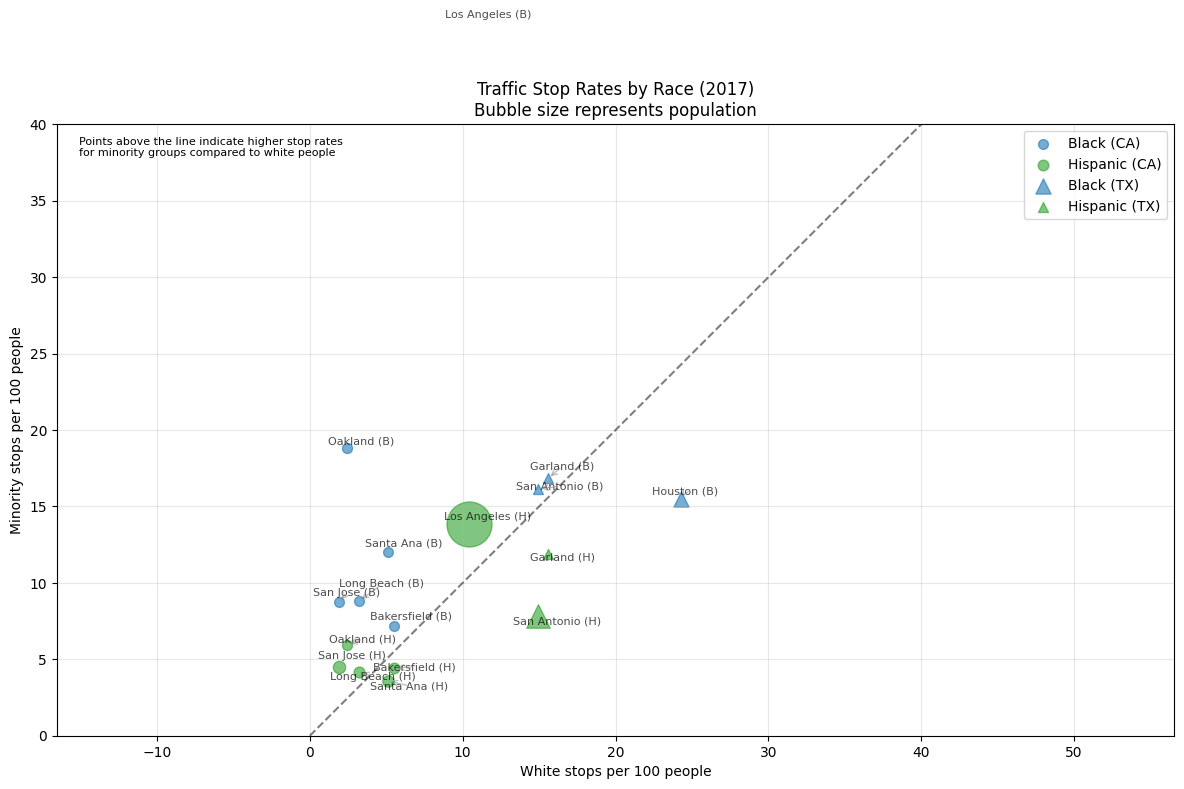

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  


# Prepare data for plotting
white_rates = []
minority_rates = []
populations = []
colors = []      # 'blue' for Black, 'green' for Hispanic
markers = []     # 'o' for CA, '^' for TX
city_labels = []

for city, races in city_race_population.items():
    if 'White' not in races:
        continue
        
    white_rate = races['White']['rate']
    state = races['state']
    marker = 'o' if state == 'ca' else '^'  # circle for CA, triangle for TX
    
    # Clean up city name for label
    clean_city = city.split(',')[0].replace(' city', '')  # Remove "city" and state
    
    # Add points for Black population if exists
    if 'Black' in races:
        white_rates.append(white_rate)
        minority_rates.append(races['Black']['rate'])
        populations.append(races['Black']['population'])
        colors.append('#1f77b4')  # blue for Black
        markers.append(marker)
        city_labels.append(f"{clean_city} (B)")
    
    # Add points for Hispanic population if exists
    if 'Hispanic' in races:
        white_rates.append(white_rate)
        minority_rates.append(races['Hispanic']['rate'])
        populations.append(races['Hispanic']['population'])
        colors.append('#2ca02c')  # green for Hispanic
        markers.append(marker)
        city_labels.append(f"{clean_city} (H)")

# Create the plot
plt.figure(figsize=(12, 8))

# Calculate point sizes with dramatic scaling
populations_array = np.array(populations)
min_pop = np.min(populations_array)
max_pop = np.max(populations_array)
normalized_pops = (populations_array - min_pop) / (max_pop - min_pop)
sizes = 50 + 1000 * (normalized_pops ** 2)

texts = []  # Store all text objects for adjustment


# Create scatter plots separately for CA and TX
for state_marker, state_name in [('o', 'CA'), ('^', 'TX')]:
    for i, (x, y) in enumerate(zip(white_rates, minority_rates)):
        if markers[i] == state_marker:
            plt.scatter(x, y, c=colors[i], s=sizes[i], alpha=0.6, 
                       marker=state_marker, label=f'{colors[i] == "#1f77b4" and "Black" or "Hispanic"} ({state_name})')
            # Add text objects to the list
            texts.append(plt.text(x, y, city_labels[i], 
                                fontsize=8, 
                                alpha=0.7))
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
           expand_points=(1.5, 1.5))
# Add diagonal line
max_val = max(max(white_rates), max(minority_rates))
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

# Customize the plot
plt.xlabel('White stops per 100 people')
plt.ylabel('Minority stops per 100 people')
plt.grid(True, alpha=0.3)
plt.title('Traffic Stop Rates by Race (2017)\nBubble size represents population')

# Make axes equal and set limits
plt.axis('equal')
plt.xlim(0, 40)
plt.ylim(0, 40)

# Add text explaining interpretation
plt.text(0.02, 0.98, 'Points above the line indicate higher stop rates\nfor minority groups compared to white people',
         transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')

# Add legend with both color and state differentiation
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()